## Exercise 2e)

In [1]:
# Autoreload
%load_ext autoreload
%autoreload 1
%aimport utils.neural_network, utils.training, utils.step_methods, utils.cost_functions, utils.activation_functions, utils.utils

# Imports
from utils.neural_network import NeuralNetwork
import numpy as np
import matplotlib.pyplot as plt
from utils.training import TrainingMethod, StochasticGradientDescent, GradientDescent
from utils.step_methods import StepMethod, RMSpropStep, AdamStep
from utils.cost_functions import MSE
from utils.activation_functions import Sigmoid, Identity, ReLU, LeakyReLU
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from utils.utils import generate_dataset, runge, plot_mse_data, analyze_model_learning_rates
from copy import deepcopy

plt.style.use('./utils/_plot_style.mplstyle')

In [2]:
# Generate dataset
np.random.seed(124)

n = 300
x, y = generate_dataset(num=n)
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2,random_state=44)

# Scale dataset
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
y_mean = y_train.mean()

In [3]:
activation_funcs = [
    ("Sigmoid", Sigmoid()),
    ("ReLU", ReLU()), 
    ("LeakyReLU",LeakyReLU())
]

regularization_types = [
    ("Lasso","L1"), 
    ("Ridge","L2")
]

training_methods = ("SGD", StochasticGradientDescent, (-4, 1))
step_methods = ("ADAM", AdamStep(0, 0.9, 0.999))

In [ ]:
n_learning_rates = 8
iterations = 3000
lamb_vals = np.logspace(-3,1,9)
all_mse_data = np.zeros((len(lamb_vals), len(regularization_types), n_learning_rates))
n_layers = 3
n_nodes = 40
activation_func = Sigmoid()

# Analyze mse vs. learning rate and number of nodes for different numbers of hidden layers and activation functions. 
for i, lamb in enumerate(lamb_vals):
    for j,(name,regularization) in enumerate(regularization_types): 
        print("Lambda: ",lamb_vals)
        _,training_method, (min_log_lr,max_log_lr) = training_methods

        learning_rates = list(np.logspace(min_log_lr, max_log_lr, n_learning_rates))

        model = NeuralNetwork(
                network_input_size = 1,
                layer_output_sizes = [n_nodes]*n_layers + [1],
                activation_funcs = [activation_func]*n_layers + [Identity()],
                cost_fun = MSE(regularization = regularization,lambd = lamb), 
                layers_random_state = 23
                )

        np.random.seed(124)
        mse_data = analyze_model_learning_rates(
            model,
            training_method(
                step_method = step_methods[1],
                inputs = x_train_scaled,
                targets = y_train - y_mean,
                test_inputs = x_test_scaled,
                test_targets = y_test - y_mean,
            ),
            learning_rates, 
            iterations,
        )
        print(".")
        all_mse_data[i][j] = mse_data

Lambda:  [1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01]
.
Lambda:  [1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01]
.
Lambda:  [1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01]
.
Lambda:  [1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01]
.
Lambda:  [1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01]
.
Lambda:  [1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01]
.
Lambda:  [1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01

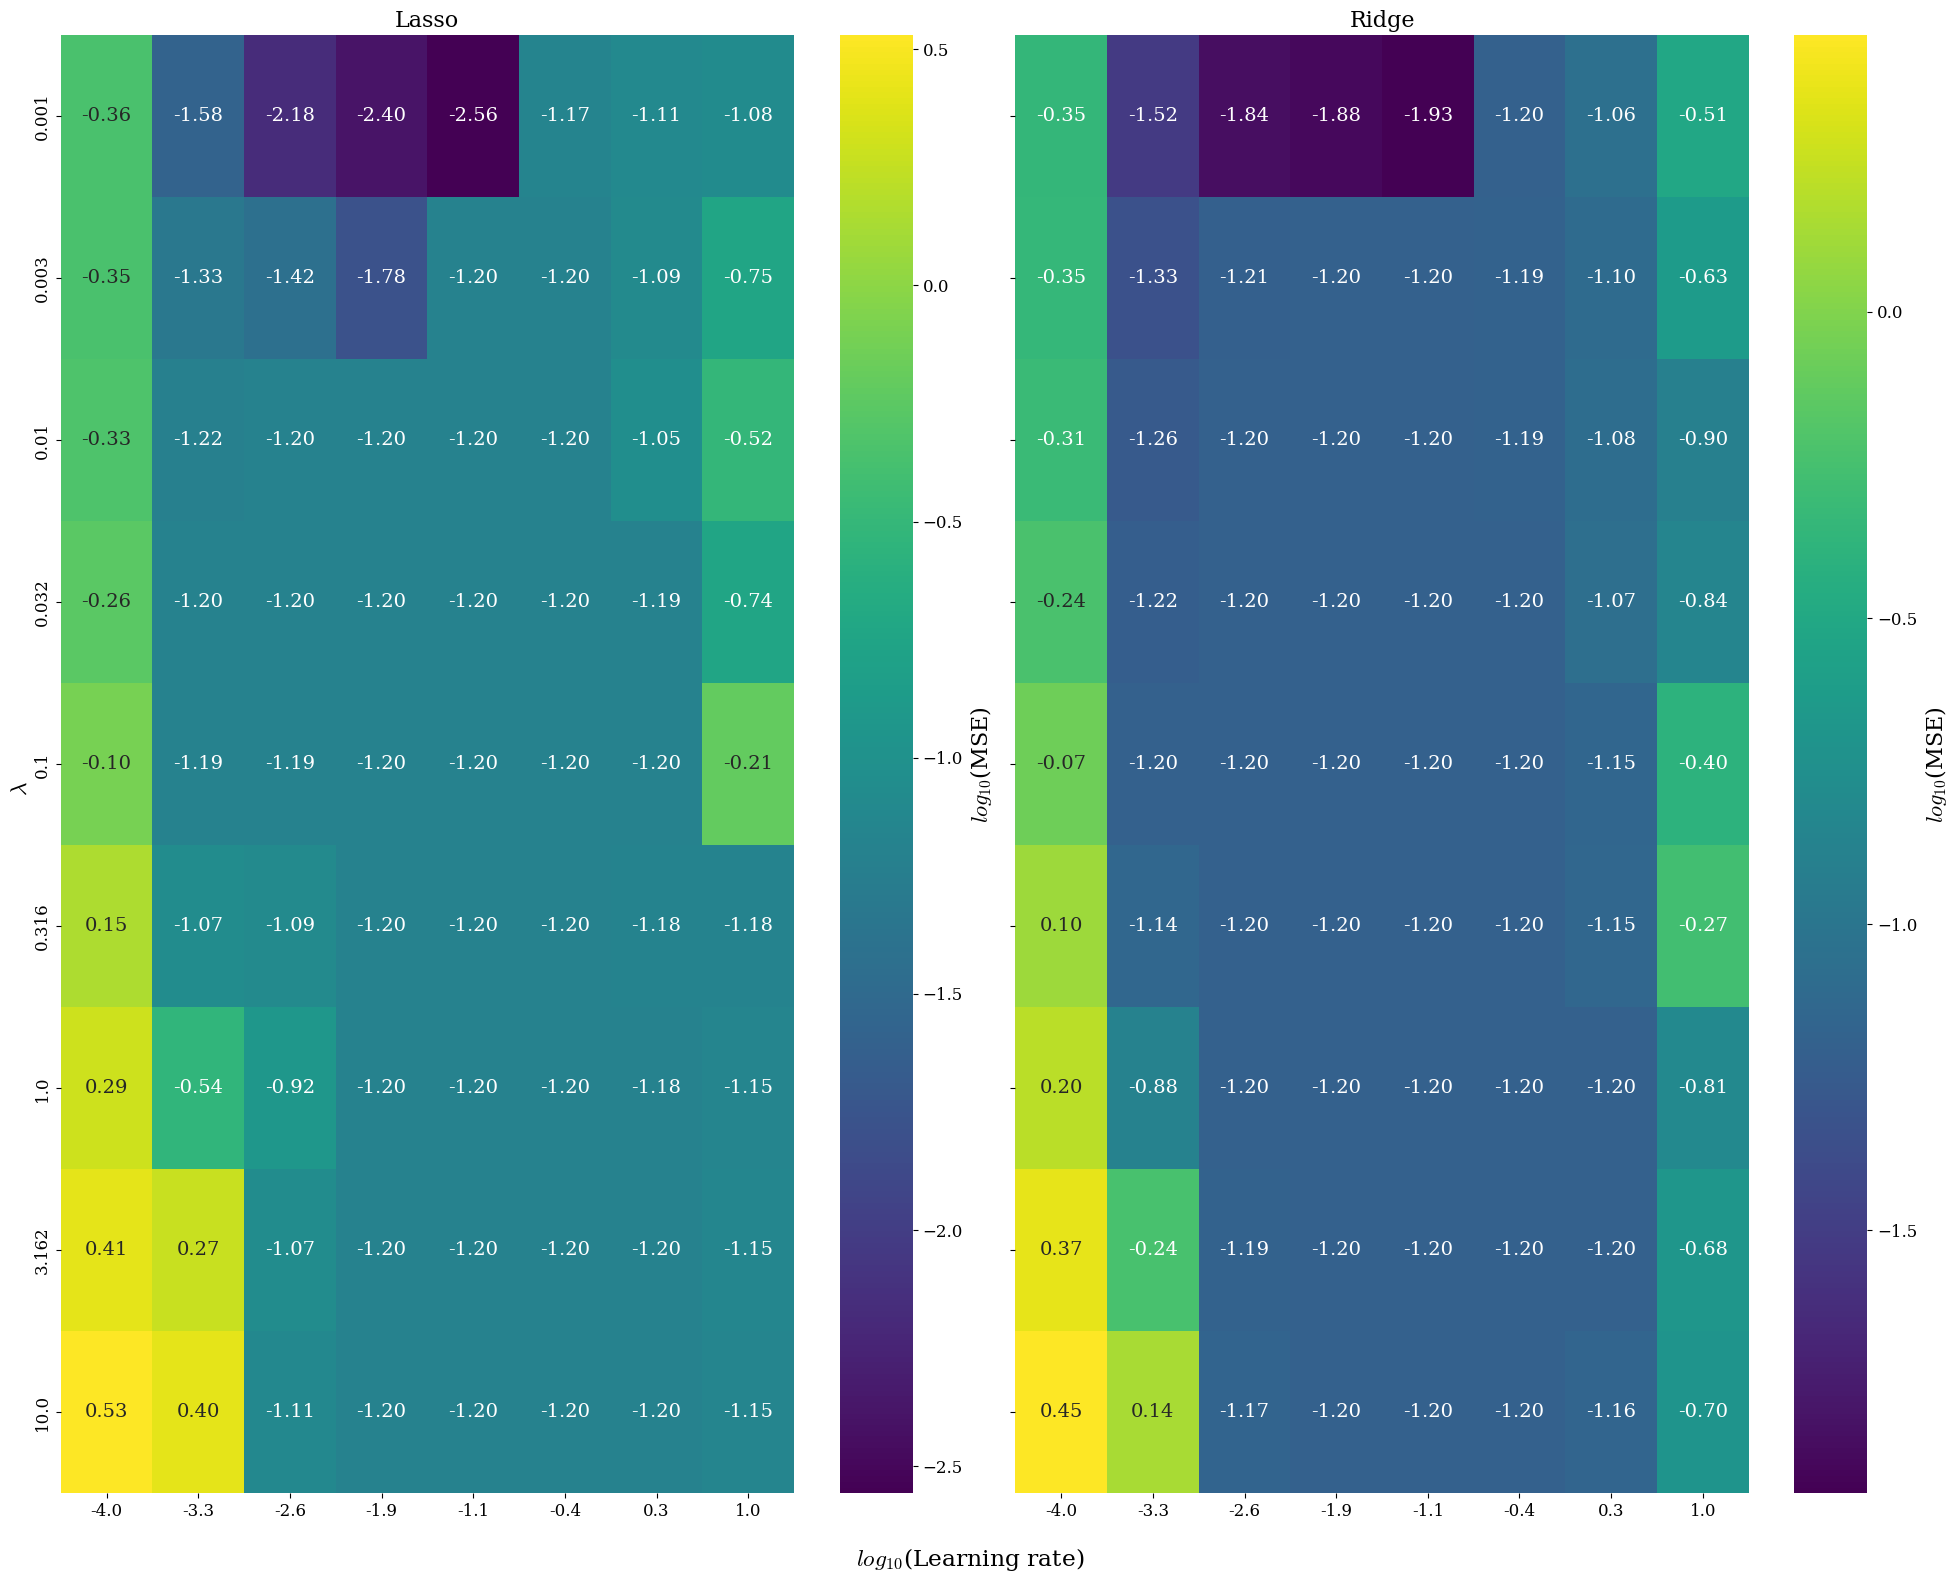

In [5]:
# Plot MSE vs. learning rates for each model

import seaborn as sns

fig, axes = plt.subplots(1, len(regularization_types), figsize=(20, 16), sharey=True)
for i,(name,regularization_type) in enumerate(regularization_types):
    mse_data = all_mse_data[:,i,:]
    sns.heatmap(
        np.log10(np.array(mse_data)),  
        ax = axes[i],
        fmt=".2f",   
        annot=True,
        cmap="viridis", 
        xticklabels=np.round(np.log10(np.array(learning_rates)),1),
        yticklabels=np.round(lamb_vals,3),cbar_kws={"label": r"$log_{10}$(MSE)"}
        )
    axes[i].set_title(f"{name}")

fig.supxlabel(r"$log_{10}$(Learning rate)")
fig.supylabel(r"$\lambda$")
plt.savefig("../figs/mse_vs_lr_nodes_reg(2).pdf")
plt.show()

In [6]:
nodes = list(range(6,31,6))
hidden_layers = [1,3,5]

iterations = 3000
all_mse_data = np.zeros((len(nodes), len(hidden_layers), len(activation_funcs),len(regularization_types)))
single_learning_rate = []

# Analyze mse vs. learning rate and number of nodes for different numbers of hidden layers and activation functions. 
for i, n_nodes in enumerate(nodes):
    print("\nNode: ",n_nodes, end="")
    for j, n_hidden_layers in enumerate(hidden_layers):
        for k, (name,activation_func) in enumerate(activation_funcs):
            for l,(name,regularization) in enumerate(regularization_types): 
                _,training_method, (min_log_lr,max_log_lr) = training_methods

                learning_rates = list(np.logspace(min_log_lr, max_log_lr, n_learning_rates))

                model = NeuralNetwork(
                        network_input_size = 1,
                        layer_output_sizes = [n_nodes]*n_hidden_layers  + [1],
                        activation_funcs = [activation_func]*n_hidden_layers + [Identity()],
                        cost_fun = MSE(regularization = regularization, lambd = 0.001), 
                        layers_random_state = 23
                        )

                np.random.seed(124)
                mse_data = analyze_model_learning_rates(
                    model,
                    training_method(
                        step_method = step_methods[1],
                        inputs = x_train_scaled,
                        targets = y_train - y_mean,
                        test_inputs = x_test_scaled,
                        test_targets = y_test - y_mean,
                    ),
                    [learning_rates[4]], 
                    iterations,
                )
                print(".",end="")
                all_mse_data[i][j][k][l] = mse_data[0]


Node:  6.

C:\Users\frede\AppData\Local\Temp\ipykernel_54956\3372860691.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_mse_data[i][j][k][l] = mse_data


.................
Node:  12..................
Node:  18..................
Node:  24..................
Node:  30..................

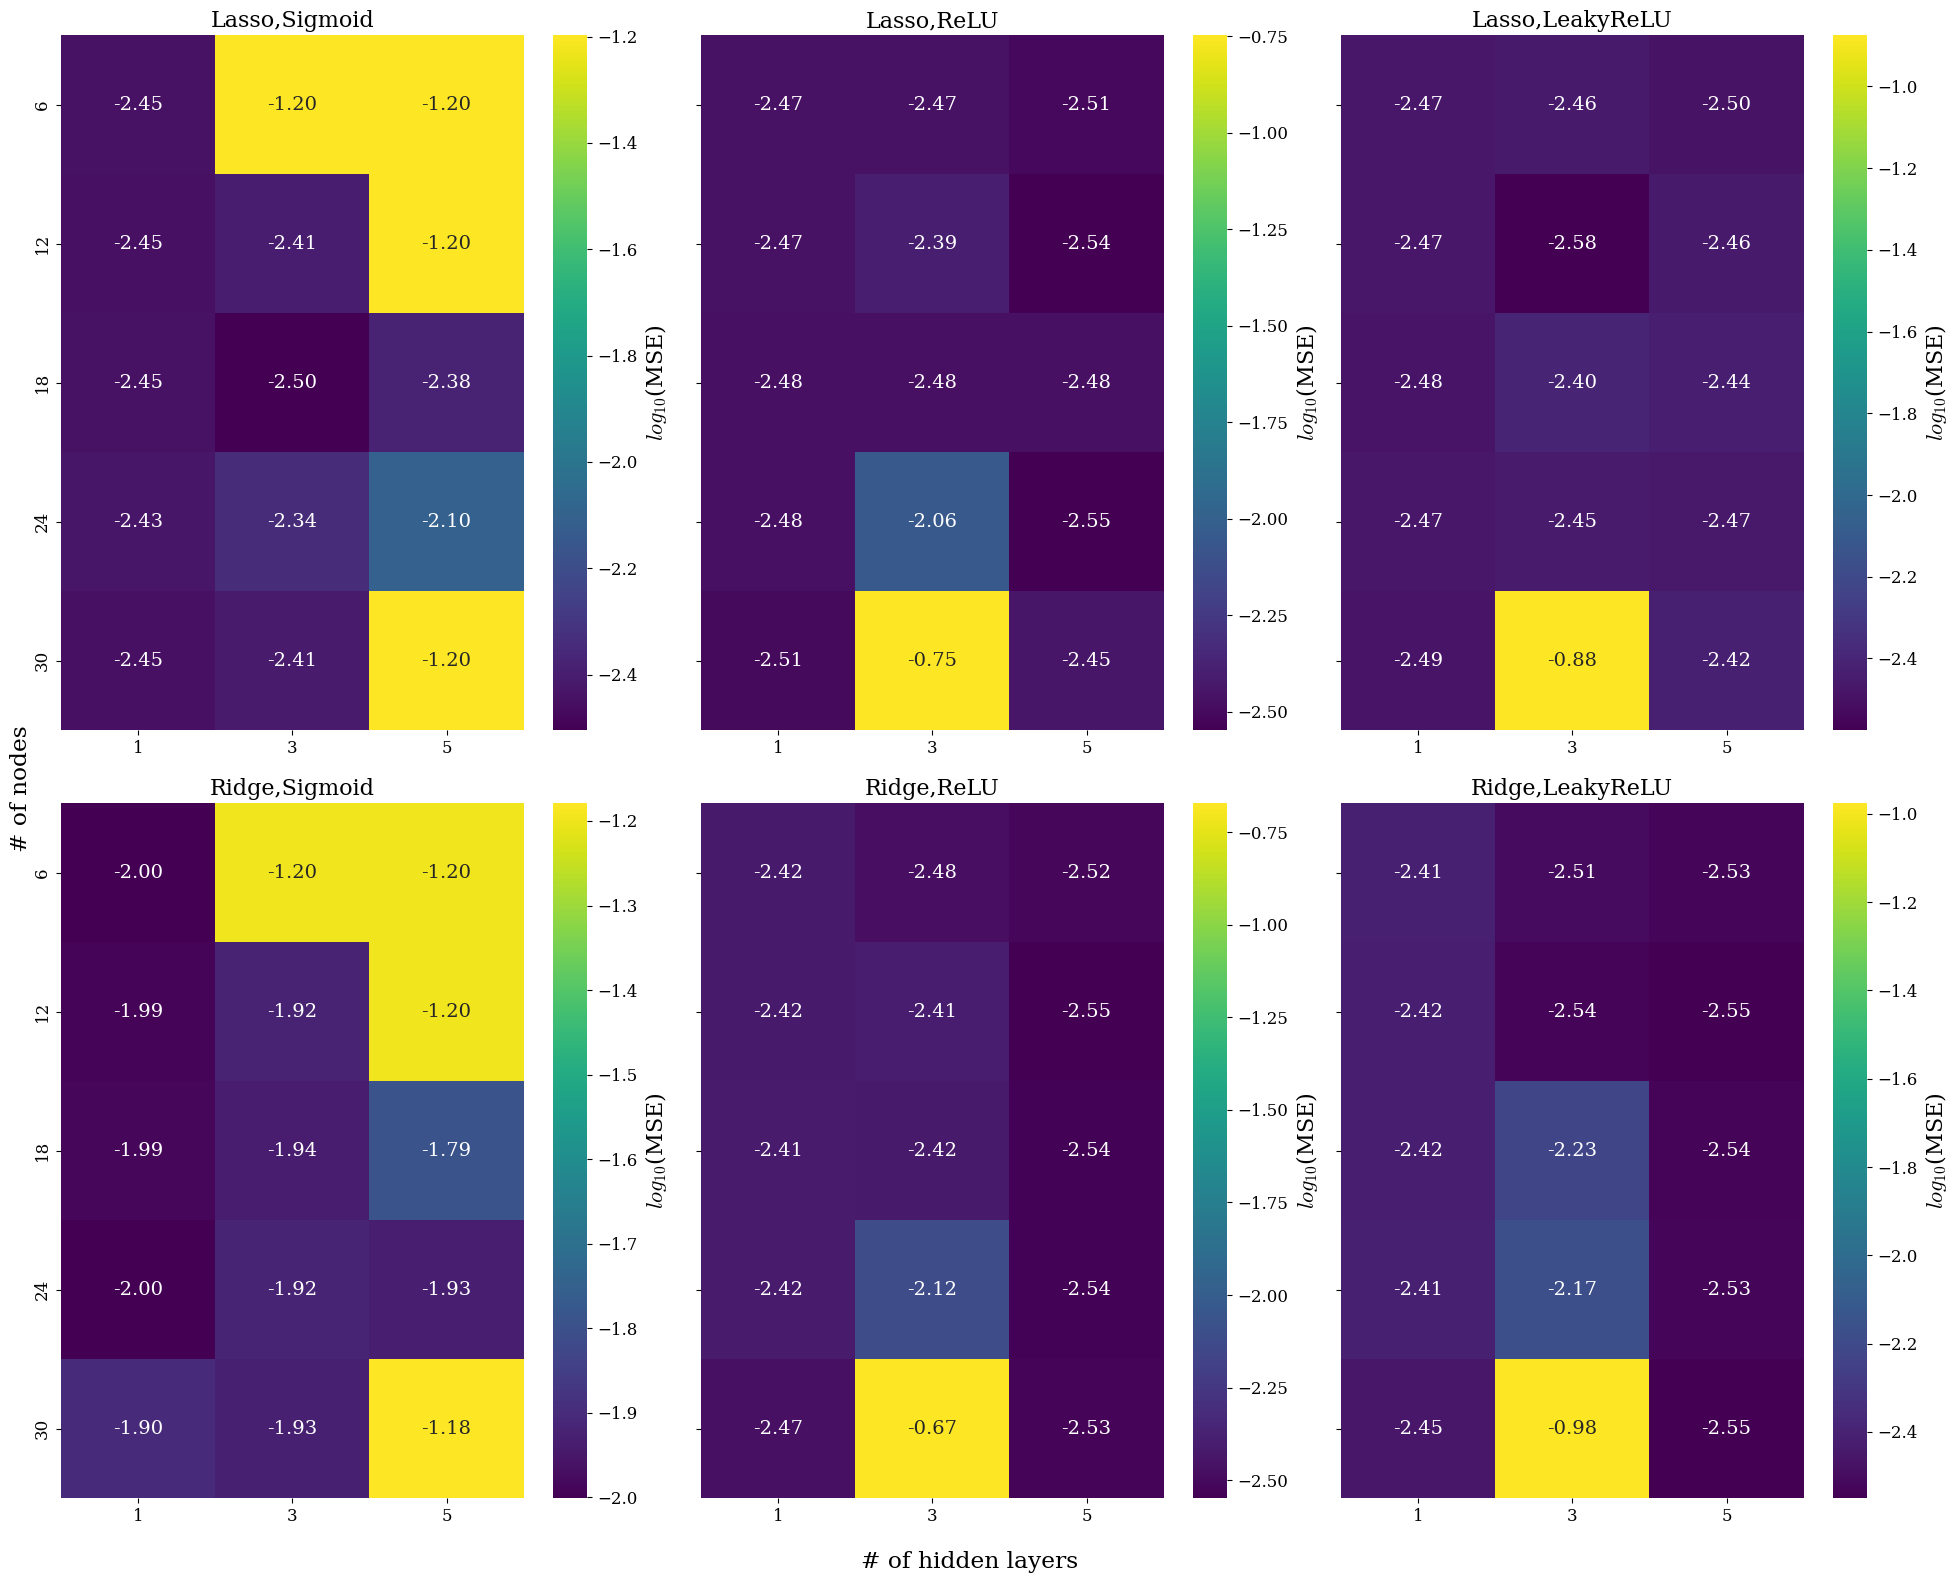

In [9]:
import seaborn as sns

fig, axes = plt.subplots(len(regularization_types),len(activation_funcs), figsize=(20, 16), sharey=True)
for l,(reg_name,regularization) in enumerate(regularization_types):
    for k, (act_name,activation_func) in enumerate(activation_funcs):
        mse_data = all_mse_data[:,:,k,l]
        sns.heatmap(
            np.log10(np.array(mse_data)),  
            ax = axes[l,k],
            fmt=".2f",   
            annot=True,
            cmap="viridis", 
            xticklabels=hidden_layers,
                                              #vmin = np.log10(np.min(all_mse_data[:,j,:,:])), vmax = np.log10(np.max(all_mse_data[:,j,:,:])),
            yticklabels=nodes,cbar_kws={"label": r"$log_{10}$(MSE)"}
            )
        axes[l,k].set_title(fr"{reg_name},{act_name}")

    fig.supxlabel(r"# of hidden layers")
    fig.supylabel("# of nodes")
plt.savefig("../figs/mse_vs_nodes_hidden_layers.pdf")
plt.show()